# Proyecto

Se tiene una cartera de 1200 personas que fueron empleados del Banco de Colombia. Dentro de los beneficios de trabajar en dicha compañía, a cada de uno de ellos se les asignó una renta vitalicia reversible, es decir, que, si el titular de la renta fallece, la renta se transfiere a su cónyuge. 
Realice la valoración para cada persona para obtener el importe total por compromiso de todas las rentas vitalicias que tiene con todos los asegurados. Es decir, cuánto me cuesta esta persona. Valor total al final. 

Propuesta de Banco de Colombia: Cambiar la renta vitalicia por un monto establecido hoy. 
Cuál es el porcentaje mínimo de tasa de aceptación para que el proyecto sea viable si Banco de Colombia quiere ahorrar al menos un 30% del valor total de la cartera. 

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys 
import os
sys.path.append(os.path.abspath('../src'))

from Tablas_mortalidad import *

In [3]:
Tmort_h = pd.read_excel('../src/TM_hombres.xlsx' )
Tmort_m = pd.read_excel('../src/TM_mujeres.xlsx' )

In [4]:
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

In [5]:
datos = pd.read_excel('../src/datos_longevidad.xlsx', sheet_name='Data')

In [6]:
# Función para calcular la valoración de jubilado
def calcular_valuacion_jubilado(tmort, edad, pago, i):
    T = tmort_filtered(tmort, edad)
    T['n'] = (T['x'] - edad) * 12
    T['Vn'] = (1 / (1 + i)) ** T['n']
    sum_vect = pago * T['Vn'] * T['p(x)']
    return sum_vect.sum()

# Función para calcular la valoración de pareja
def calcular_valuacion_pareja(tmort, edad, pago, edad_pareja, i):
    T = tmort_filtered(tmort, edad)
    T['n'] = (T['x'] - edad) * 12
    T['Vn'] = (1 / (1 + i)) ** T['n']
    sum_vect = pago * T['Vn'] * T['p(x)']
    va_jubilado = sum_vect.sum()

    # Calcular la valoración de la pareja
    if edad <= edad_pareja:
        T_par = tmort_filtered(tmort, edad_pareja)
        T_par['n'] = (T_par['x'] - edad_pareja) * 12
        T_par['Vn'] = (1 / (1 + i)) ** T_par['n']
        T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
    else:
        T_par = tmort_filtered(tmort, edad_pareja)
        T_par['n'] = (T_par['x'] - edad_pareja) * 12
        T_par['Vn'] = (1 / (1 + i)) ** T_par['n']
        gap = (edad - edad_pareja) * 12
        T_par['q(x)_Jub'] = list(T['q(x)']) + [1] * gap

    sum_vect_pareja = pago * T_par['Vn'] * T_par['p(x)'] * T_par['q(x)_Jub']
    va_pareja = sum_vect_pareja.sum()
    return va_jubilado, va_pareja

In [7]:
# Parámetros
i = 0.04 / 12
v_jubilado = []
v_pareja = []

# Iterar sobre los datos y calcular las valoraciones
for index, row in datos.iterrows():
    genero = row['Genero']
    pago = row['Pago_mensual']
    edad = row['Edad']
    
    # Seleccionar la tabla de mortalidad según el género
    tmort = T_hombre if genero == 'H' else T_mujer

    # Calcular valoración de jubilado y pareja
    if row['Casado'] == 0:
        va_jubilado = calcular_valuacion_jubilado(tmort, edad, pago, i)
        va_pareja = 0
    elif row['Casado'] == 1:
        va_jubilado, va_pareja = calcular_valuacion_pareja(tmort, edad, pago, row['Edad_pareja'], i)

    v_jubilado.append(va_jubilado)
    v_pareja.append(va_pareja)

# Actualizar el dataframe con las nuevas columnas
datos['Valoracion Jubilado'] = v_jubilado
datos['Valoracion pareja'] = v_pareja
datos['Pago_mensual'] = datos['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
datos['Valoracion'] = datos['Valoracion Jubilado'] + datos['Valoracion pareja']

# Mostrar resultados
datos

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,921,951.40","1,346,661,606.16"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...,...
1195,1196,78,0,M,0,0,"2,994,379.20","640,482,469.74",0.00,"640,482,469.74"
1196,1197,72,1,M,69,H,"3,778,424.20","877,935,210.33","36,067,363.78","914,002,574.11"
1197,1198,76,0,M,0,0,"3,839,464.83","846,745,509.27",0.00,"846,745,509.27"
1198,1199,77,0,H,0,0,"10,827,760.94","2,348,062,669.86",0.00,"2,348,062,669.86"


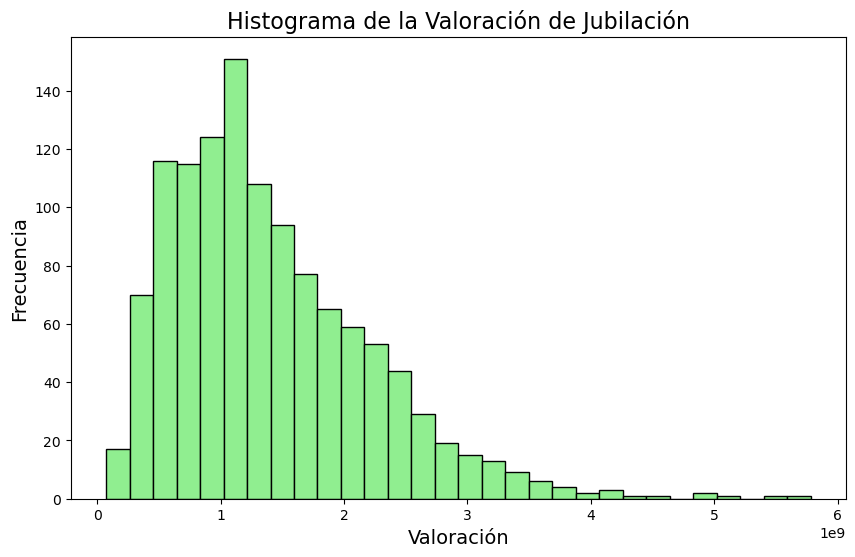

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(datos['Valoracion'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma de la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

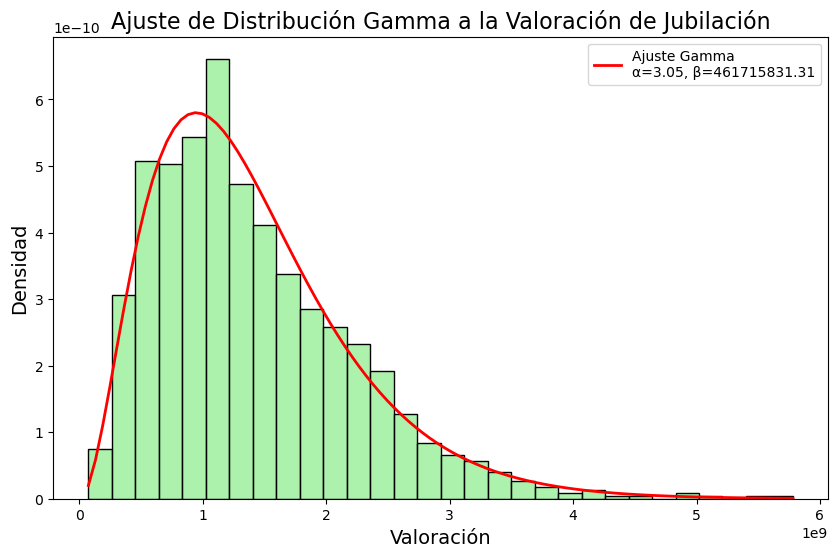

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
params = gamma.fit(datos['Valoracion'], floc=0) 

xmin, xmax = datos['Valoracion'].min(), datos['Valoracion'].max()
x = np.linspace(xmin, xmax, 100)
pdf_fitted = gamma.pdf(x, *params)  
plt.figure(figsize=(10, 6))
sns.histplot(datos['Valoracion'], bins=30, kde=False, color='lightgreen', stat='density', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Ajuste Gamma\nα={params[0]:.2f}, β={params[2]:.2f}')
plt.title('Ajuste de Distribución Gamma a la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.legend()
plt.show()